In [8]:
import requests
import logging
import json
from datetime import datetime
from bluesky.callbacks import CallbackBase
from pprint import pformat

def getInvestigationIDFromTitle(session_id, title_string):
    url = 'https://icat.helmholtz-berlin.de/icatplus/catalogue/'+session_id+'/investigation'
    header = {'Content-Type': 'application/json'}
    proxies = {"http": "http://www.bessy.de:3128", "https": "https://www.bessy.de:3128"}
    response = requests.get(url, headers=header, proxies=proxies)
    response_data = (json.loads(response.text))
    for item in response_data:
        title = str(item['title'])
        #Select the id with the title Test: ingest for SISSY
        if title == title_string:
            investigation_id = str(item['id'])
            
    return investigation_id

def getInvestigationIDFromName(session_id, name_string):
    url = 'https://icat.helmholtz-berlin.de/icatplus/catalogue/'+session_id+'/investigation'
    header = {'Content-Type': 'application/json'}
    proxies = {"http": "http://www.bessy.de:3128", "https": "https://www.bessy.de:3128"}
    response = requests.get(url, headers=header, proxies=proxies)
    response_data = (json.loads(response.text))
    for item in response_data:
        name = str(item['name'])
        #Select the id with the title Test: ingest for SISSY
        if name_string in name:
            investigation_id = str(item['id'])
            
    return investigation_id

def getSessionID(username, password):
    proxies = {"http": "http://www.bessy.de:3128", "https": "https://www.bessy.de:3128"}
    header = {'Content-Type': 'application/json'}
    data = {"plugin":"hzbrex","username":username,"password":password}
    response = requests.post('https://icat.helmholtz-berlin.de/icatplus/session', headers=header,data=json.dumps(data), proxies=proxies)
    response_data = json.loads(response.text)
    session_id = response_data['sessionId']
    return session_id



def writeToELog(message, username, password, title_string):
    # make a new comment with the machine tag
    now = datetime.now()
    dt_string = now.strftime("%m/%d/%Y %H:%M:%S") # Note the American format.
    html_event_with_tag ={
    "type":"annotation",
    "category":"comment",
    "content":[
        {
            "text":"<p>"+str(message)+"</p>",
            "format":"html"
    }],
    "creationDate":dt_string,
    "tag": [
    "60deb980e105e3001a3daa2a"
    ]
    } # The tag is used to write "machine"

    #get session id
    proxies = {"http": "http://www.bessy.de:3128", "https": "https://www.bessy.de:3128"}
    session_id = getSessionID(username,password)
    
    #get investigation_id
    investigation_id = getInvestigationID(session_id,title_string)
    
    url = 'https://icat.helmholtz-berlin.de/icatplus/logbook/' + session_id + '/investigation/id/'+ investigation_id+ '/event/create'
    header = {'Content-Type': 'application/json'}
    data = html_event_with_tag
    response = requests.post(url, headers=header,data=json.dumps(data), proxies=proxies)

    return response.status_code

In [16]:

from getpass import getpass


def requestInvestigationName(username,password):

    session_id = getSessionID(username,password)

    url = 'https://icat.helmholtz-berlin.de/icatplus/catalogue/'+session_id+'/investigation'
    header = {'Content-Type': 'application/json'}
    proxies = {"http": "http://www.bessy.de:3128", "https": "https://www.bessy.de:3128"}
    response = requests.get(url, headers=header, proxies=proxies)
    response_data = (json.loads(response.text))


    #Request the title or some of it, or the investigation id

    part_title = input(f"\nEnter part or all of the investigation title or ID: ")
    possible_investigations = []
    for item in response_data:

        title = str(item['title'])
        id_num = str(item['name'])
        Distance = lev.distance(title.lower(),part_title.lower())
        Ratio = lev.ratio(title.lower(),part_title.lower())

        if part_title in title or part_title.lower() in title.lower() or Ratio > 0.8 or Distance < 10 or part_title in id_num:
            possible_investigations.append(item)

    index_sel = 1
    if len(possible_investigations) >1:
        print(f"Here are the investigations we found ")
        for i, investigation in enumerate(possible_investigations):
            print(f"    {i+1}. {investigation['title']}")

        index_sel = int(input(f"\nWhich is the correct investigtion: "))

    title = possible_investigations[index_sel-1]['title']
    name = possible_investigations[index_sel-1]['name'].split(':')[1]
    id_num = possible_investigations[index_sel-1]['id']

    
    return title, name, id_num

username =str(input("username: "))
password = str(getpass())


title, name, id_num = requestInvestigationName(username,password)
                                                  
print(f"Data will now be saved in ICAT with investigation: \n\n name:   {title} \n\n ID:   {name}")
print(f"\n\nYou can reach the eLog here: https://icat.helmholtz-berlin.de/datahub/investigation/{id_num}/events")
    

username:  qqu
 ·····


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [13]:



from jinja2 import Template
template ="""
{{- plan_name }} ['{{ uid[:6] }}'] (scan num: {{ scan_id }})
<br>Scan Plan
<br>---------
<br>{{ plan_name }}
{% if 'plan_args' is defined %}
    {%- for k, v in plan_args | dictsort %}
        <br>{{ k }}: {{ v }}
    {%-  endfor %}
{% endif %}"""


j2_template = Template(template)


end_template ="""
Plan ended
<br>exit_status: {{exit_status}}
<br>num_events: {{num_events}}
<br>uid:{{run_start}}"""


j2_end_template = Template(end_template)

class MyELogCallback(CallbackBase):
    
    def __init__(self, username, password, title):
        self.username = username
        self.password = password
        self.title_string = title

        
        
    def start(self, doc):
        
        writeToELog(j2_template.render(doc),self.username,self.password,self.title_string)
        
    def descriptor(self, doc):
        # Do Somthing
        pass
    def event(self, doc):
        pass
        # Do something
    def stop(self, doc):
        
      
        writeToELog(j2_end_template.render(doc),self.username,self.password,self.title_string)
    

In [29]:
# Create a test run engine and attach our callback

from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()
RE.subscribe(bec)
# Send all metadata/data captured to the BestEffortCallback.


#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)

In [ ]:
from bluesky.callbacks.zmq import RemoteDispatcher
d = RemoteDispatcher('localhost:5578')
d.subscribe(print)

# when done subscribing things and ready to use:
d.start()  # runs event loop forever

In [ ]:
# Offer the user a list of available titles



from getpass import getpass

username =str(input("username: "))
password = str(getpass())

In [29]:
from getpass import getpass

username =str(input("username: "))
password = str(getpass())
title = "Test: ingest for SISSY"
RE.subscribe(MyELogCallback(username, password,title))

username:  qqu
 ········


2



Transient Scan ID: 1     Time: 2021-10-03 00:36:55
Persistent Unique Scan ID: '512580cf-ae9e-4be2-8a34-7a76999d9ebe'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 00:36:56.3 |     -1.000 |      0.607 |
|         2 | 00:36:56.3 |     -0.778 |      0.739 |
|         3 | 00:36:56.4 |     -0.556 |      0.857 |
|         4 | 00:36:56.4 |     -0.333 |      0.946 |
|         5 | 00:36:56.4 |     -0.111 |      0.994 |
|         6 | 00:36:56.5 |      0.111 |      0.994 |
|         7 | 00:36:56.5 |      0.333 |      0.946 |
|         8 | 00:36:56.5 |      0.556 |      0.857 |
|         9 | 00:36:56.6 |      0.778 |      0.739 |
|        10 | 00:36:56.6 |      1.000 |      0.607 |
+-----------+------------+------------+------------+
generator scan ['512580cf'] (scan num: 1)





('512580cf-ae9e-4be2-8a34-7a76999d9ebe',)

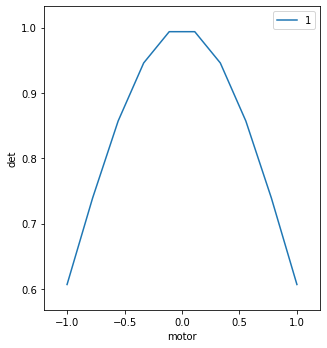

In [30]:
from bluesky.plans import scan
from ophyd.sim import det, motor

RE(scan([det],motor, -1,1,10))

In [ ]:
# See notes here about running callbacks elsewhere on a network: https://blueskyproject.io/bluesky/callbacks.html#subscriptions-in-separate-processes-or-host-with-0mq

In [ ]:
#Should write to the eLog here